In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.patheffects as path_effects
import seaborn as sns
from unicodedata import normalize
import re
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob



In [8]:
# # pip install sqlalchemy pg8000 
# # !pip install sqlalchemy_utils
# !pip install wordcloud textblob

In [9]:
from sqlalchemy import create_engine, exists, MetaData, Table, BigInteger, Boolean,CHAR, select,  Column, DateTime, Integer, String, insert, update
from sqlalchemy.orm import sessionmaker, Session
from sqlalchemy_utils import database_exists, create_database
# from github_setup import postgresql as settings
from sqlalchemy.ext.declarative import declarative_base
from twitter_config import pins


url = f"postgresql+pg8000://{pins['user']}:{pins['password']}@{pins['host']}:{pins['port']}/{pins['db_name']}"

engine = create_engine(url)

Session = sessionmaker(bind=engine)

Base = declarative_base()

In [10]:
class Twitter(Base):
    """twitter table"""

    __tablename__ = "twitter"
    
    tweet_id = Column(String, primary_key=True)
    asa_id   = Column(String)
    user_id  = Column(String) 
    text     = Column(String)
    posted_at= Column(DateTime)   
    hashtags = Column(String)
    

class Interactions(Base):
    """Interactions table"""

    __tablename__ = "interactions"

    tweet_id = Column(String, primary_key=True)
    likes = Column(Integer)
    retweets = Column(Integer)
    protected = Column(Boolean)
    
class Historical_tweets(Base):
    """ Historical tweet table"""
    
    __tablename__ = "historical_tweets"
    
    id = Column(BigInteger, primary_key = True)
    date = Column(DateTime)
    user_id = Column(BigInteger)
    text = Column(String)
    retweets = Column(Integer)
    likes = Column(Integer)
    mentionedusers = Column(String)
    asa_id = Column(String)
    


Base.metadata.create_all(engine)


In [12]:
db = Session()

In [13]:
id_twitter = db.query(Twitter).all()

id_inter = db.query(Interactions).all()

id_hist = db.query(Historical_tweets).all()


In [18]:
len(id_hist)

25413

### Transform class  tested !!!!!!!

In [62]:
class Transform():
    def __init__(self):
        self.data = None
    
    def get_twitter_df(self, ids, twitter_col:list):
        data = []
        for i in range(len(ids)):
            a,b,c,d,e,f = ids[i].tweet_id, ids[i].asa_id, ids[i].user_id, ids[i].text, ids[i].posted_at, ids[i].hashtags
            arr = np.array([a,b,c,d,e,f])
            data.append(arr)
        array = np.array(data)
        df = pd.DataFrame(array, columns = twitter_col)
        return df
    
    def get_inter_df(self, ids, inter_col:list):
        data = []
        for i in range(len(ids)):
            a,b,c,d = ids[i].tweet_id, ids[i].likes, ids[i].retweets, ids[i].protected
            arr = np.array([a,b,c,d])
            data.append(arr)
        array = np.array(data)
        df = pd.DataFrame(array, columns = inter_col)
        return df

    def get_hist_df(self, ids, twitter_col:list):
        data = []
        for i in range(len(ids)):
            a,b,c,d,e,f,g,h = ids[i].id, ids[i].date, ids[i].user_id, ids[i].text, \
            ids[i].retweets, ids[i].likes, ids[i].mentionedusers, ids[i].asa_id
            arr = np.array([a,b,c,d,e,f,g,h])
            data.append(arr)
        array = np.array(data)
        df = pd.DataFrame(array, columns = twitter_col)
        return df
    
    def merge_dfs(self, df1, df2):
        df = pd.merge(df1, df2, how = 'inner', on = 'tweet_id')
        
        return df
    
    def clean_tweet(self, tweet):
        tweet = normalize('NFKD', tweet).encode('ascii', 'ignore').decode('utf-8')
        tweet = str(tweet)
        tweet = re.sub('(RT\s(@\w+))', '', tweet)
        tweet = re.sub('@\\w+', '', tweet)

        tweet = re.sub('((http|https):(\S+))', '', tweet)
        tweet = re.sub('[!#?:*%$]', ' ', tweet)
        tweet = re.sub('[^\s\w+]', '', tweet)
        tweet = re.sub('[\n]', '', tweet)
        tweet = tweet.lower().strip()
        return tweet
    
    def clean_id(self,df, column, historical = False):
        new = []
        for s in df[column]:
            s = s.lower()
            if not historical:
                
                n = s.replace('{', '')
                n = n.replace('}', '')
            else:
                n = s.replace('[', '')
                n = n.replace(']', '')
            new.append(n)
        df[column] = new
        return df
    
    def fix_type(self, df):
#         data = self.data
        for i in df.columns:
            if i in ['likes', 'retweets']:
                df[i] = df[i].astype('int64')
            if i in ['protected']:
                df[i] = df[i].astype(bool)
            
        return df
    
    def choose_asa(self, df):
#         data = self.data
        asa = input("Hey there! \nWhat ASA would you like to analyze? ").lower()
        data_asa = df[df['asa_id'].str.contains(asa, case = False)]
        data_asa.reset_index(inplace = True)
        return data_asa
    
    def alll(self, historical = False):
        col_t = ['tweet_id', 'asa_id', 'user_id', 'text', 'posted_at', 'hashtags']
        col_i = ['tweet_id', 'likes', 'retweets', 'protected']
        col_hist = ['id', 'date', 'user_id', 'text', 'retweets', 'likes', 'mentionedusers', 'asa_id']

        if historical:
            
            df_hist = self.get_hist_df(id_hist, col_hist)
            df_hist['clean_tweet'] = df_hist.text.apply(self.clean_tweet)
            df_hist = self.clean_id(df_hist, 'asa_id', historical = True)
            df_hist = self.fix_type(df_hist)
            df_final = self.choose_asa(df_hist)    
            
        else:
            
            df_twitter = self.get_twitter_df(id_twitter, col_t)
            df_inter = self.get_inter_df(id_inter, col_i)
            df = self.merge_dfs(df_twitter, df_inter)
            df['clean_tweet'] = df.text.apply(self.clean_tweet)
            df = self.clean_id(df, 'asa_id')
            df = self.fix_type(df)
            df_final = self.choose_asa(df)
        return df_final
        


In [26]:

# df_t = Transform().get_hist_df(id_hist, col)
# df_t.head()

In [27]:
# df_t.tail()

In [83]:
df_c = Transform().alll(historical = True)

Hey there! 
What ASA would you like to analyze? choice


In [30]:
df_algom = Transform().alll(historical = True)

Hey Nigga! 
What ASA would you like to analyze? algomint


In [85]:
df_yieldly = Transform().alll(historical = True)

Hey there! 
What ASA would you like to analyze? yieldly


In [88]:
df_shosha = Transform().alll(historical = True)

Hey there! 
What ASA would you like to analyze? shosha


In [89]:
df_c.shape, df_algom.shape, df_yieldly.shape, df_shosha.shape

((528, 10), (3867, 12), (1426, 10), (638, 10))

## Likes class tested and works with transform

In [41]:
class Likes():
    
    def __init__(self, data, entity_col:str, datetime_col):
        
        self.data = data
        self.entity_col = entity_col
        self.datetime_col = data[datetime_col]
    
    def day_of_week(self):
        data = self.data
        date = self.datetime_col
        day = date.dt.weekday
        data['day_of_week'] = day.to_list()
        encode_dict = {0: 'Sunday', 1:'Monday', 2:'Tuesday',
                        3: 'Wednesday', 4: 'Thursday',
                        5: 'Friday', 6: 'Saturday'}
        data['day_of_week'] = data['day_of_week'].replace(encode_dict)

        return data
    def hour_of_day(self):
        data = self.data
        date = self.datetime_col
        time = date.dt.hour
        data['hour_of_day'] = time.to_list()
        return data
    def plot(self, weekday = False, timeofday = False):
        data = self.data
        entity = self.entity_col
#         if weekday & timeofday:
#             df1 = self.DayOfWeek()
#             h = df1.groupby('day_of_week')['retweets'].sum()
#             df2 = self.TimeOfDay()
#             c = df2.groupby('hour_of_day')['likes'].sum()
#             plt.bar(h.index, h)
#             plt.plot(c)
#             plt.show()
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(12,4))
        
        if weekday:
            df = self.day_of_week()
            h = df.groupby('day_of_week')[entity].sum()
            plt.title(f'{entity} per day of the week')
            plt.xlabel('day of the week')
            plt.ylabel(f'{entity}')
            plt.bar(h.index, h, color=['green'])
            plt.show()
        elif timeofday:
            df = self.hour_of_day()
            c = df.groupby('hour_of_day')[entity].sum()
            plt.title(f'Trend of {entity} per hour of day')
            plt.xlabel('Hour of the day')
            plt.ylabel(f'{entity}')
            plt.plot(c, 'g-o',path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
            plt.show()

        else:
            
            plt.title(f"Trend of {entity}")
            plt.ylabel(f'{entity}')
            plt.xlabel('index')
            plt.plot(data[entity], 'g-o', path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
#         return p
    


### Choice Coin

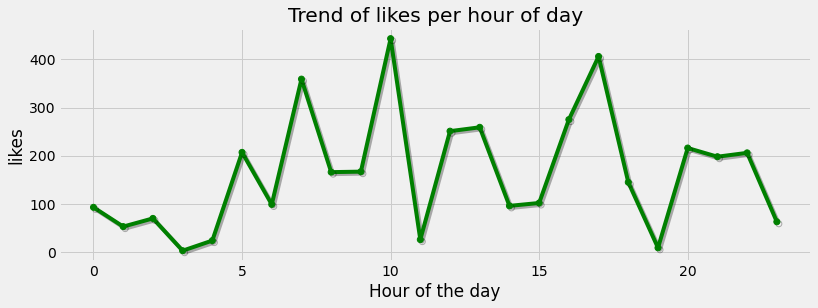

In [90]:
choice = Likes(df_c, 'likes', 'date')
choice.plot(timeofday=True)


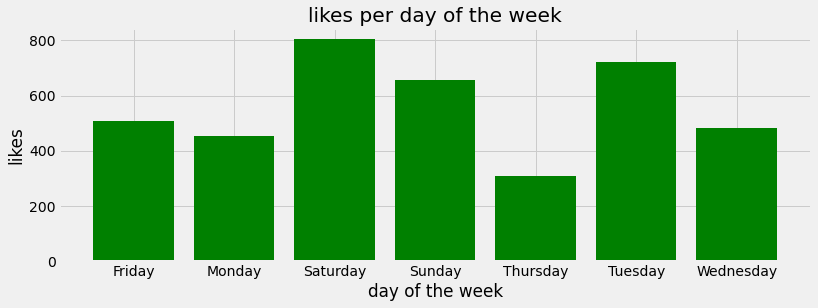

In [91]:
choice.plot(weekday = True)

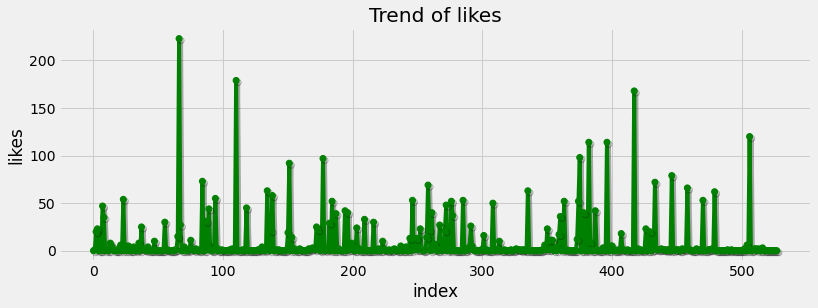

In [92]:
choice.plot()

In [93]:
class Retweets(Likes):
    pass
    

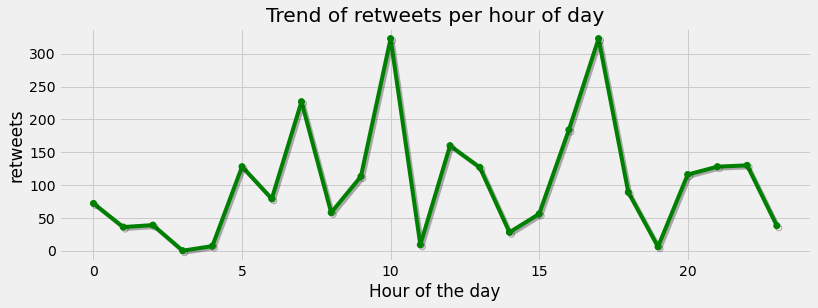

In [94]:
choice_ret = Retweets(df_c, 'retweets', 'date')
choice_ret.plot(timeofday=True)


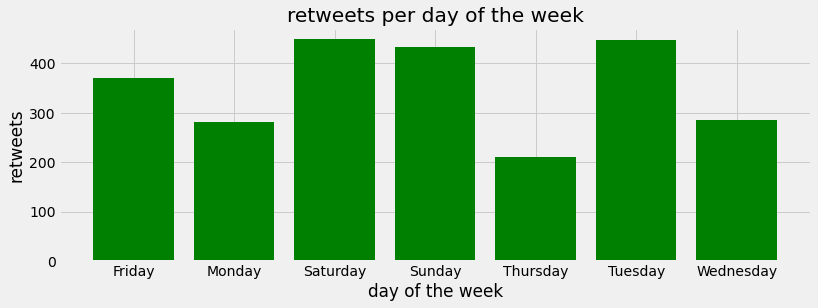

In [95]:
choice_ret.plot(weekday = True)

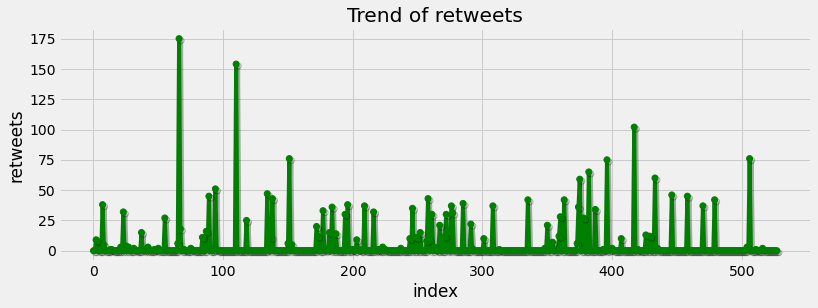

In [96]:
choice_ret.plot()

In [97]:
class Text():
    
    def __init__(self, df, column:str):
        self.df = df
        self.column = column
        self.text = df[column]
        
    def wordcloud(self):
        text = self.text
        
        comment_words = ''
        stopwords = set(STOPWORDS)
 
        # iterate through the csv file
        for val in text:
     
            # typecaste each val to string
            val = str(val)
 
            # split the value
            tokens = val.split()
     
            # Converts each token into lowercase
            for i in range(len(tokens)):
                tokens[i] = tokens[i].lower()
     
            comment_words += " ".join(tokens)+" "
 
        wordcloud = WordCloud(width = 900, height = 300,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
        # plot the WordCloud image 
        plt.style.use('fivethirtyeight')
        plt.figure(figsize = (15, 10), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
 
        return plt.show()
        
    def sentiment(self):
        df = self.df
        column = self.df
        text = self.text
        senti = []
        score = [TextBlob(t).sentiment.polarity for t in text ]
        for s in score:
            if s > 0:
                senti.append(1)
            elif s == 0:
                senti.append(0)
            else:
                senti.append(-1)
        df['sentiment_score'] = senti
        return df
    def plot_sentiment(self):
        df = self.sentiment()
        
        code = {1: 'positive', -1: 'negative', 0:'neutral'}
        df['sentiment_score'].replace(code, inplace = True)
        s = df['sentiment_score'].value_counts()
        
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(12,4))
        plt.title('Sentiment Analysis')
        plt.xlabel('Category')
        plt.ylabel('Score')
        plt.bar(s.index, s, color=['green'])
        plt.show()
        

In [99]:
df_c.columns

Index(['index', 'id', 'date', 'user_id', 'text', 'retweets', 'likes',
       'mentionedusers', 'asa_id', 'clean_tweet', 'hour_of_day',
       'day_of_week'],
      dtype='object')

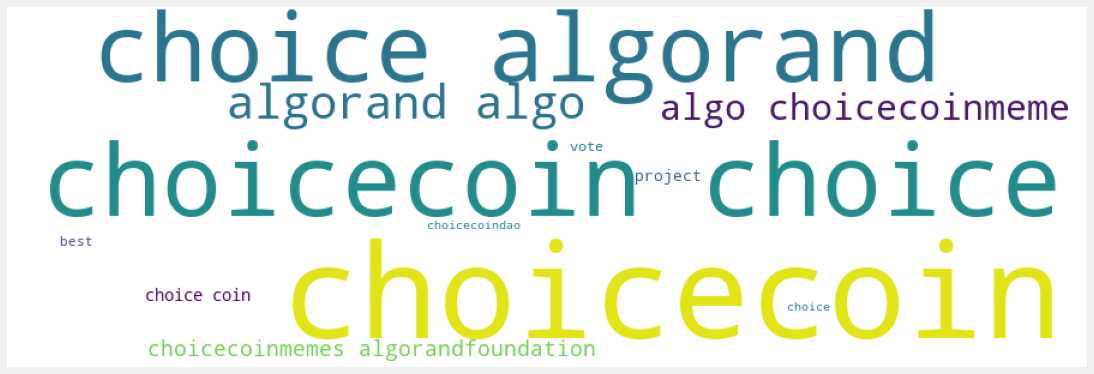

In [98]:
choice_t = Text(df_c, 'clean_tweet')
choice_t.wordcloud()

In [103]:
choice_t.sentiment().head()

,index,id,date,user_id,text,retweets,likes,mentionedusers,asa_id,clean_tweet,hour_of_day,day_of_week,sentiment_score
0,263,1519737936140541953,2022-04-28 17:58:53,3047701923,@ChoiceCoinDAO @ChoiceCoinAlgo @ChoiceCoinArmy...,0,0,"[User(username='ChoiceCoinDAO', id=14095698427...","'choicecoin', 'choicecoin', 'choicecoin', 'cho...",with choicecoin wagmi is sure,17,Wednesday,1
1,311,1519650070760759296,2022-04-28 12:09:45,1454536431301500935,@ChoiceCoinDAO @patrickbennett @JohnMizzoni @i...,0,1,"[User(username='ChoiceCoinDAO', id=14095698427...","'choicecoin', 'yieldly', 'choicecoin'",our number one choice,12,Wednesday,0
2,325,1481273313783693312,2022-01-12 14:34:13,1449480472002801664,"Make decisions, Get rewarded!\n\n""Having the p...",9,20,None,'choicecoin',make decisions get rewarded having the privile...,14,Tuesday,1
3,349,1481245515509641219,2022-01-12 12:43:45,1449480472002801664,"The Testimonies Keep Pouring! \n $CHOICE\n""It ...",8,23,None,'choicecoin',the testimonies keep pouring choiceit feels...,12,Tuesday,1
4,368,1519364829789700098,2022-04-27 17:16:18,871340587135488004,@tinymanorg @PeraAlgoWallet Lets go @CryptoTre...,0,0,"[User(username='tinymanorg', id=13892315544388...","'shoshacrypto', 'choicecoin'",lets go,17,Tuesday,0


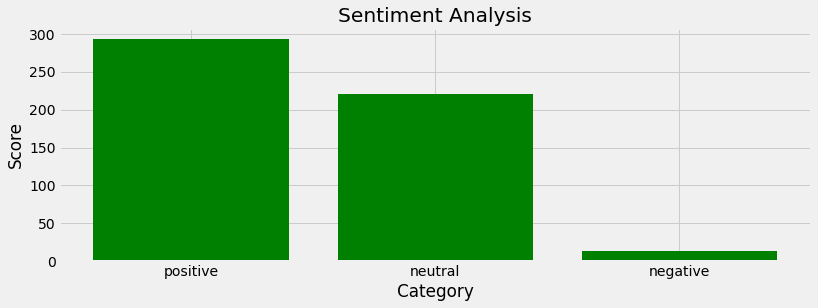

In [101]:
choice_t.plot_sentiment()

### Algomint

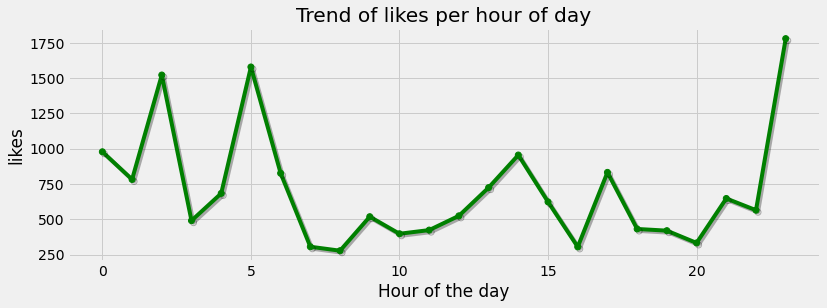

In [104]:
mint = Likes(df_algom, 'likes', 'date')
mint.plot(timeofday=True)


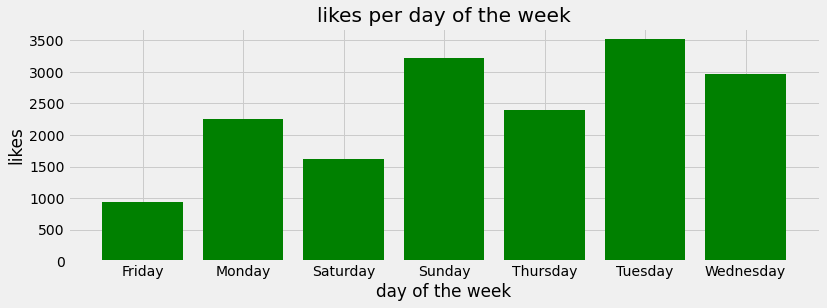

In [105]:
mint.plot(weekday = True)


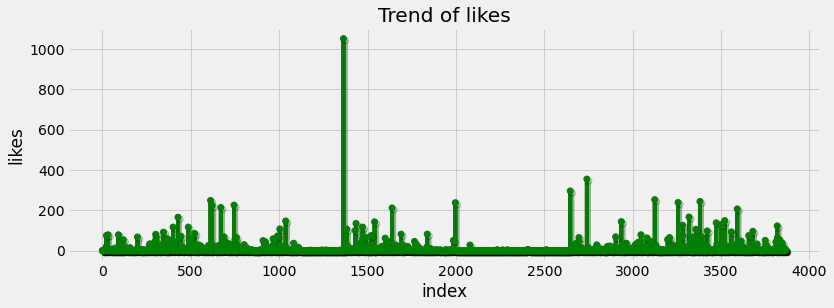

In [106]:
mint.plot()

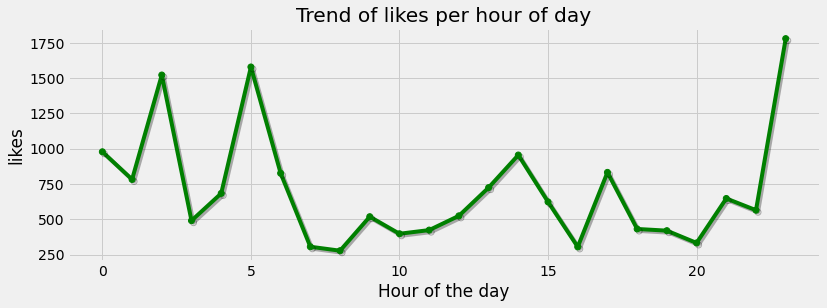

In [107]:
mint_r = Retweets(df_algom, 'likes', 'date')
mint_r.plot(timeofday=True)


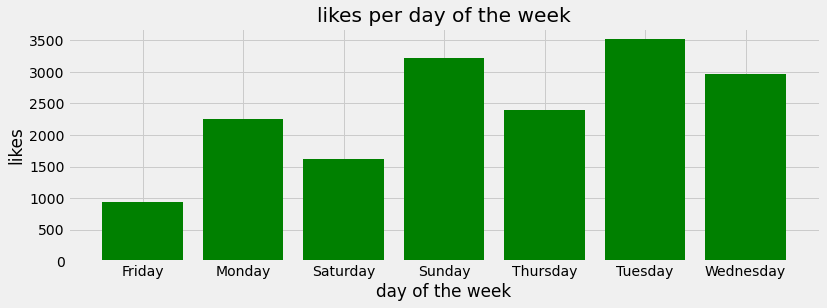

In [108]:
mint_r.plot(weekday = True)


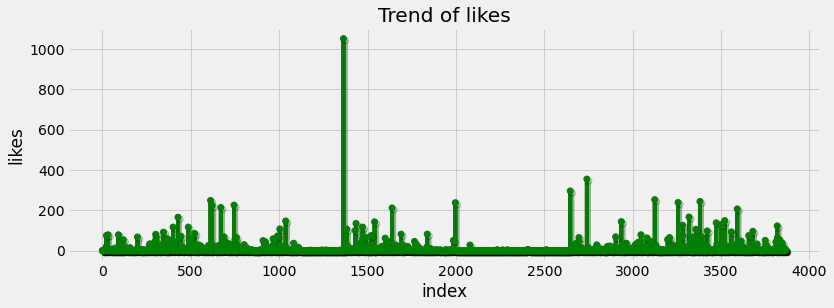

In [109]:
mint_r.plot()

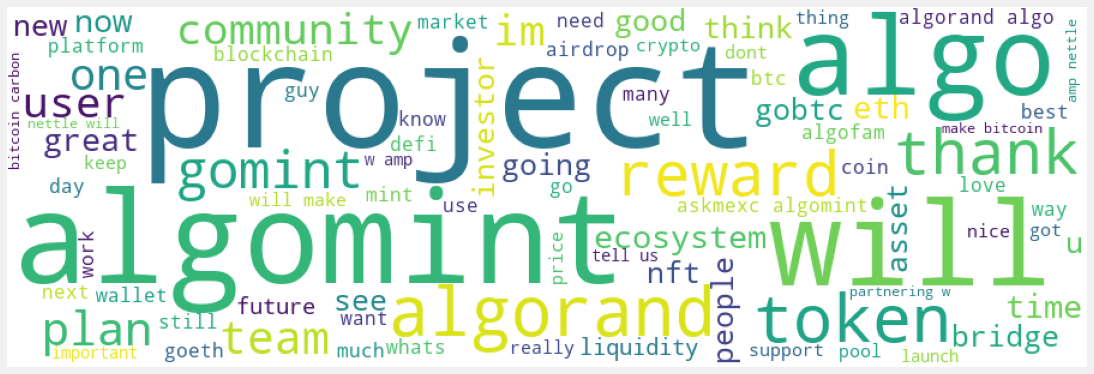

In [110]:
mint_t = Text(df_algom, 'clean_tweet')
mint_t.wordcloud()

In [112]:
mint_t.sentiment().head()

,index,id,date,user_id,text,retweets,likes,mentionedusers,asa_id,clean_tweet,hour_of_day,day_of_week,sentiment_score
0,2,1520178274290315266,2022-04-29 23:08:38,1433639716751040517,@coin_trades How will this be different than @...,0,0,"[User(username='coin_trades', id=1291649306953...",'algomint_io',how will this be different than,23,Thursday,0
1,6,1520171697114128386,2022-04-29 22:42:30,1447425654736109574,@RileyLe82657391 @Algorand @algofiorg @pact_fi...,0,0,"[User(username='RileyLe82657391', id=123537915...","'algofiorg', 'algomint_io'",all made the list already,22,Thursday,0
2,7,1520169146704707591,2022-04-29 22:32:22,1044164759610957824,@RileyLe82657391 @Algorand @algofiorg @pact_fi...,0,0,"[User(username='RileyLe82657391', id=123537915...","'algofiorg', 'algomint_io'",all made the list already,22,Thursday,0
3,8,1520168856274284544,2022-04-29 22:31:13,1235379152531963904,@HouseofChimera @Algorand Current favorite= @a...,0,1,"[User(username='HouseofChimera', id=1044164759...","'algofiorg', 'algomint_io'",current favorite,22,Thursday,1
4,35,1520104669963599872,2022-04-29 18:16:10,1321571272443240451,@Cardalgo1 Don’t count @deflyapp and @XfiniteO...,0,1,"[User(username='Cardalgo1', id=915331561217712...",'algomint_io',dont count and out just yet i think theres...,18,Thursday,0


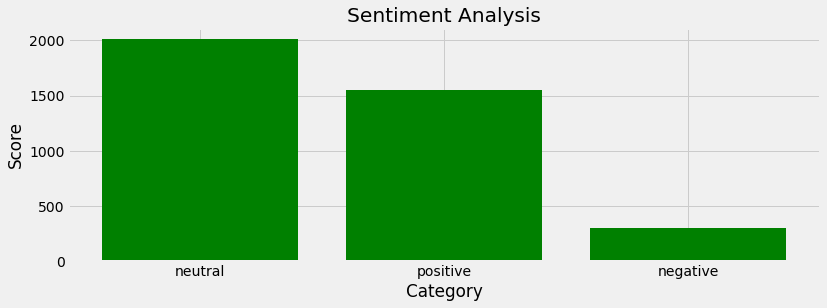

In [113]:
mint_t.plot_sentiment()

### Yieldly

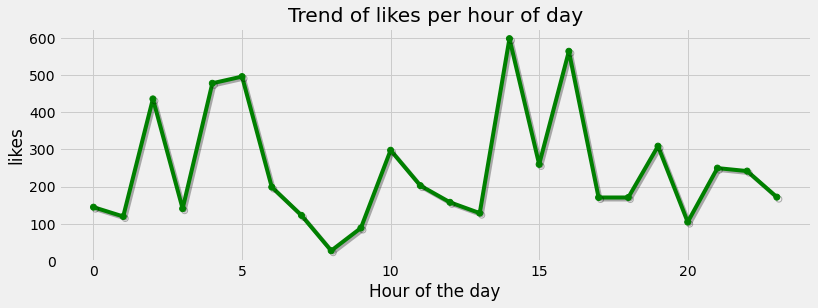

In [114]:
yieldly = Likes(df_yieldly, 'likes', 'date')
yieldly.plot(timeofday=True)


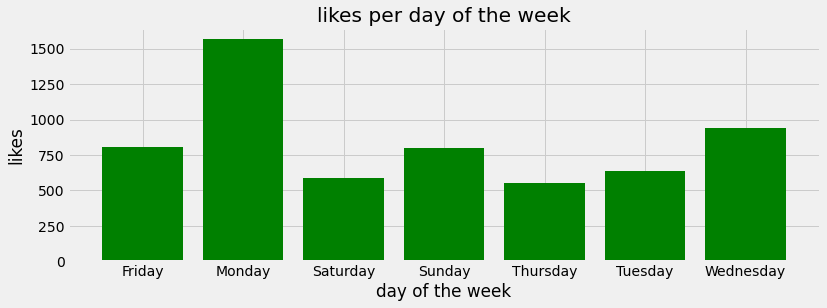

In [115]:
yieldly.plot(weekday = True)


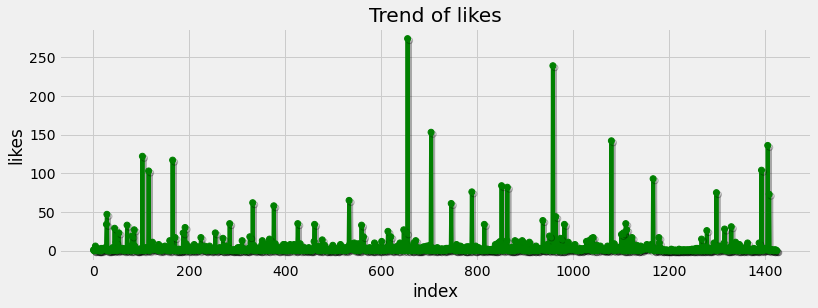

In [116]:
yieldly.plot()

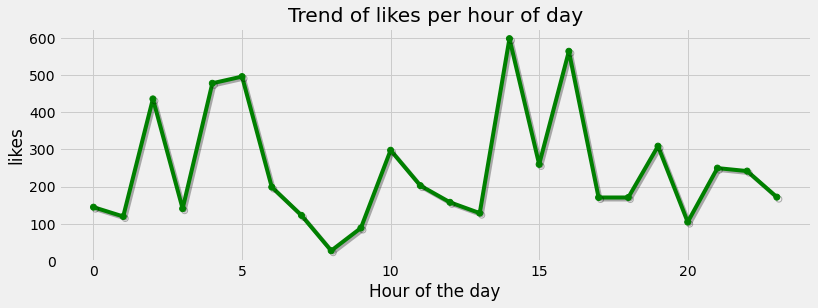

In [117]:
yieldly_r = Retweets(df_yieldly, 'likes', 'date')
yieldly_r.plot(timeofday=True)


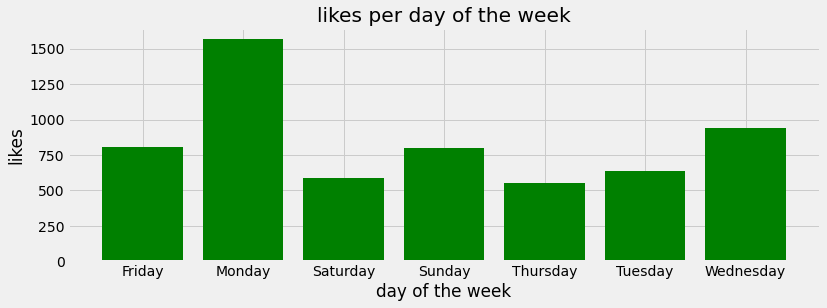

In [118]:
yieldly_r.plot(weekday = True)


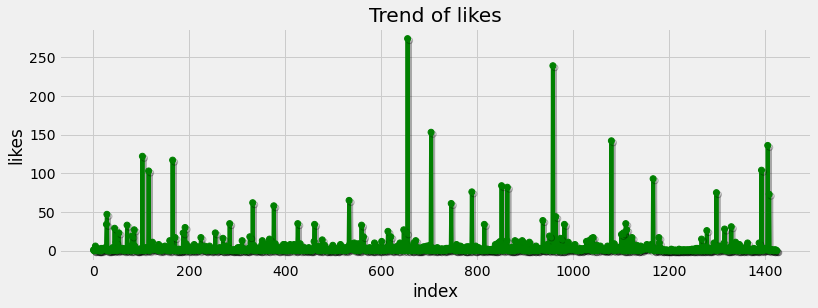

In [119]:
yieldly_r.plot()

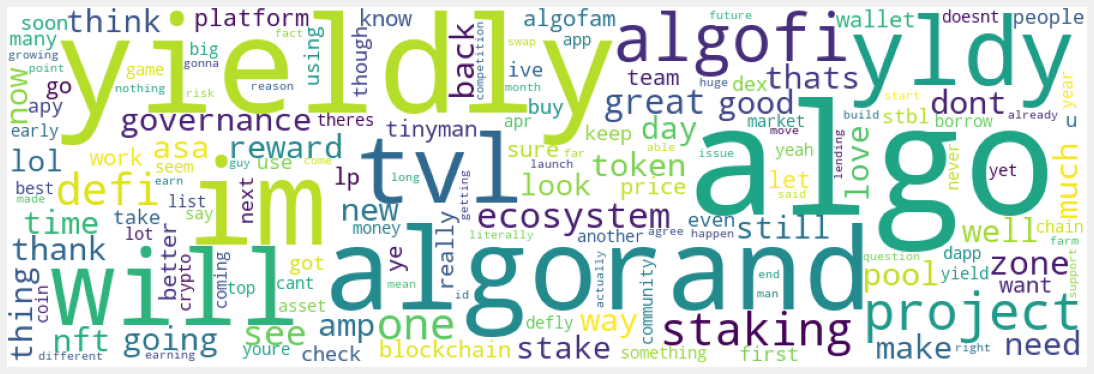

In [120]:
yieldly_t = Text(df_yieldly, 'clean_tweet')
yieldly_t.wordcloud()

In [122]:
yieldly_t.sentiment().head()

,index,id,date,user_id,text,retweets,likes,mentionedusers,asa_id,clean_tweet,hour_of_day,day_of_week,sentiment_score
0,24,1520124582996459520,2022-04-29 19:35:17,2275560857,@crypttortue @PeraAlgoWallet @myalgo_ @algofio...,0,1,"[User(username='crypttortue', id=1400143067013...","'algofiorg', 'algogemsnft', 'yieldly'",,19,Thursday,0
1,38,1520091920462192643,2022-04-29 17:25:30,1480359332575334401,Imagina quando a galera descobrir:\n@algofiorg...,0,0,"[User(username='algofiorg', id=139625526259653...","'algofiorg', 'yieldly'",imagina quando a galera descobrir defi...,17,Thursday,0
2,138,1519911678179426305,2022-04-29 05:29:17,1358230977621839872,@AirdropsMine good performance\n@algofiorg \n@...,0,0,"[User(username='AirdropsMine', id=148148718046...","'algofiorg', 'yieldly'",good performance,5,Thursday,1
3,311,1519650070760759296,2022-04-28 12:09:45,1454536431301500935,@ChoiceCoinDAO @patrickbennett @JohnMizzoni @i...,0,1,"[User(username='ChoiceCoinDAO', id=14095698427...","'choicecoin', 'yieldly', 'choicecoin'",our number one choice,12,Wednesday,0
4,518,1518980919574605824,2022-04-26 15:50:47,1328761300630048778,STAKING WITH #ALGORAND! HOW TO USE #ALGORAND #...,1,6,"[User(username='PeraAlgoWallet', id=1475829828...","'algofiorg', 'yieldly'",staking with algorand how to use algorand ...,15,Monday,0


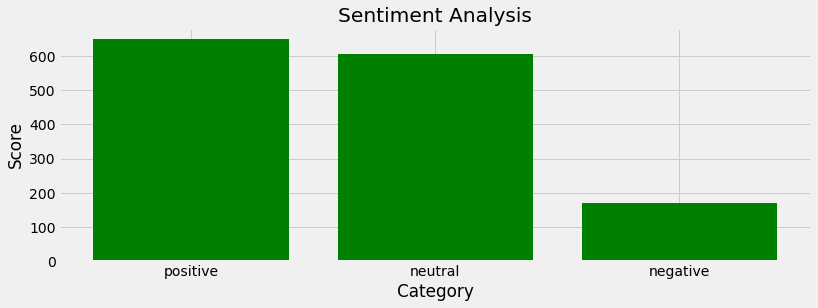

In [123]:
yieldly_t.plot_sentiment()

### Shosha

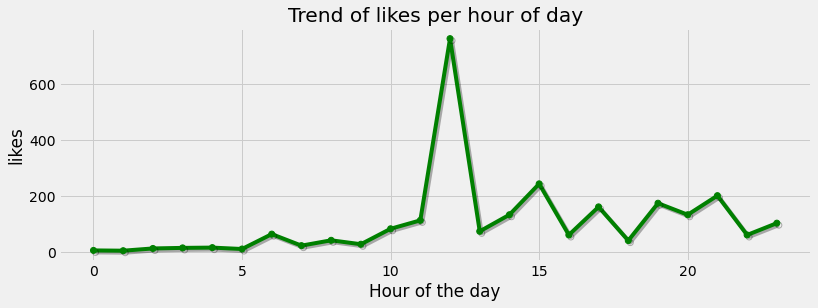

In [124]:
shosha = Likes(df_shosha, 'likes', 'date')
shosha.plot(timeofday=True)


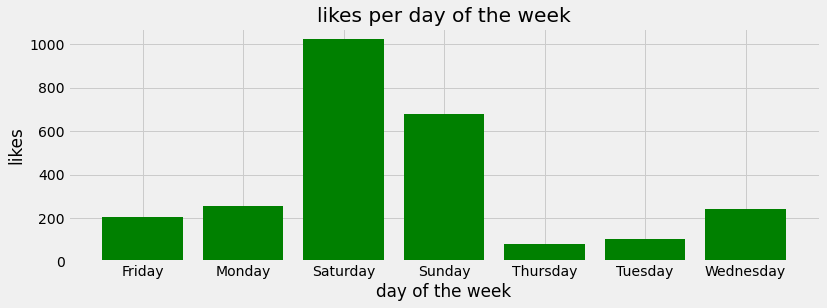

In [125]:
shosha.plot(weekday = True)


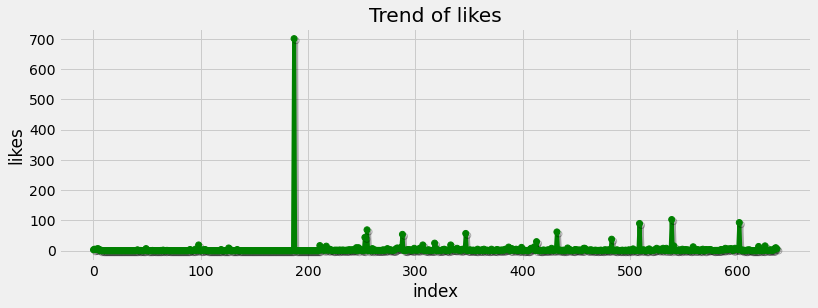

In [126]:
shosha.plot()

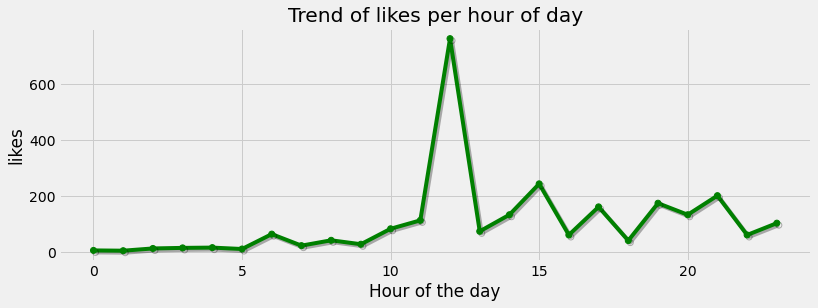

In [127]:
shosha_r = Retweets(df_shosha, 'likes', 'date')
shosha_r.plot(timeofday=True)


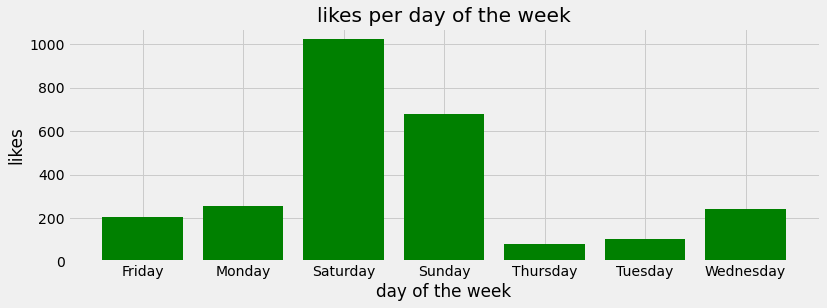

In [128]:
shosha_r.plot(weekday = True)


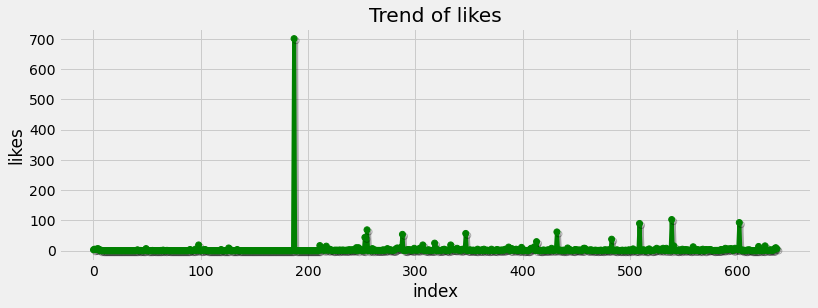

In [129]:
shosha_r.plot()

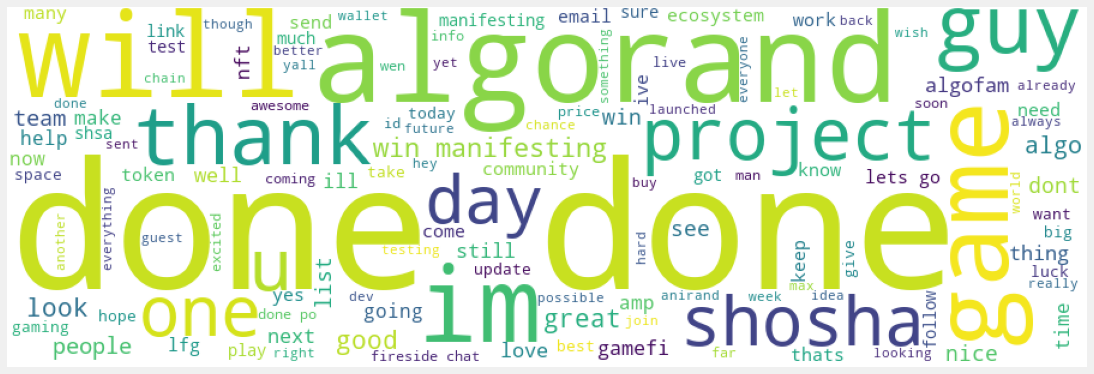

In [130]:
shosha_t = Text(df_shosha, 'clean_tweet')
shosha_t.wordcloud()

In [132]:
shosha_t.sentiment().head()

,index,id,date,user_id,text,retweets,likes,mentionedusers,asa_id,clean_tweet,hour_of_day,day_of_week,sentiment_score
0,173,1519870214980182018,2022-04-29 02:44:31,1452845055778115585,@angry_penguins1 @gtaggallery @Extremebulls @S...,0,3,"[User(username='angry_penguins1', id=146751200...",'shoshacrypto',,2,Thursday,0
1,175,1519867693742305280,2022-04-29 02:34:30,1467512006286581761,@gtaggallery @Algorand @AlgoGods @NRPG_officia...,0,5,"[User(username='gtaggallery', id=1512693964968...",'shoshacrypto',,2,Thursday,0
2,176,1519867015770820608,2022-04-29 02:31:48,1467512006286581761,@gtaggallery @Extremebulls @ShoshaCrypto @digi...,0,4,"[User(username='gtaggallery', id=1512693964968...",'shoshacrypto',,2,Thursday,0
3,206,1519828001612959746,2022-04-28 23:56:47,1492590050550632448,@gtaggallery @Algorand @AlgoGods @NRPG_officia...,0,5,"[User(username='gtaggallery', id=1512693964968...",'shoshacrypto',lfg,23,Wednesday,0
4,209,1519826906379702272,2022-04-28 23:52:26,1464362881659637762,@gtaggallery @Algorand @AlgoGods @NRPG_officia...,0,7,"[User(username='gtaggallery', id=1512693964968...",'shoshacrypto',,23,Wednesday,0


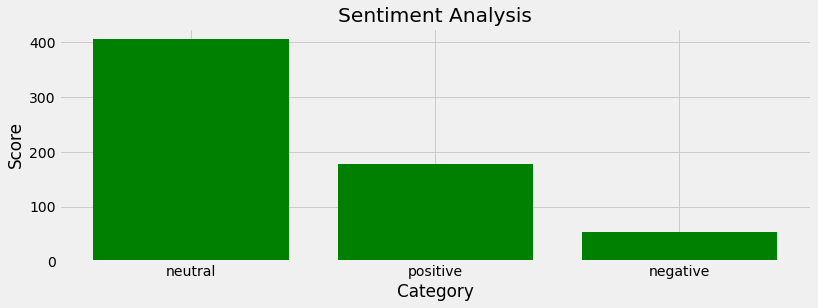

In [133]:
shosha_t.plot_sentiment()